In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Sequential,backend, callbacks, optimizers ,metrics, Model, losses
from tensorflow.keras.layers import Dense, Activation, Input, BatchNormalization
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from keras.optimizers import Adam

In [2]:
train_features = pd.read_csv('train_features.csv')
train_target_scored = pd.read_csv('train_targets_scored.csv')
test_features = pd.read_csv('test_features.csv')

In [3]:
gene_features = []
cell_features = []
for col in train_features.columns:
    if col.startswith('g-'):
        gene_features.append(col)
    if col.startswith('c-'):
        cell_features.append(col)

print(f'Gene feature count: {len(gene_features)}')
print(f'Cell feature count: {len(cell_features)}')

train_merge = pd.merge(train_features, train_target_scored, on = 'sig_id', how = 'left')

Gene feature count: 772
Cell feature count: 100


In [4]:
from sklearn.preprocessing import LabelEncoder
x = train_merge.copy()
le = LabelEncoder()
x['cp_type'] = le.fit_transform(x['cp_type'])
x['cp_time'] = le.fit_transform(x['cp_time'])
x['cp_dose'] = le.fit_transform(x['cp_dose'])

test_features['cp_type'] = le.fit_transform(test_features['cp_type'])
test_features['cp_time'] = le.fit_transform(test_features['cp_time'])
test_features['cp_dose'] = le.fit_transform(test_features['cp_dose'])

In [5]:
target_cols = [col for col in train_target_scored.columns if col not in ['sig_id']]
y = x[target_cols]

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set the random seed for reproducibility
tf.random.set_seed(42)

# Assuming x[cell_features] is a DataFrame or similar, converting to numpy array for processing
x_cell_features = np.array(x[cell_features])
X_train, X_val = train_test_split(x_cell_features, test_size=0.2, random_state=42)

# Define learning rate schedule and optimizer
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)
optimizer = Adam(learning_rate=lr_schedule)

# Model architecture
inputs = Input(shape=(100,))  # Ensure the input shape matches the number of cell features
encoder_1 = Dense(90, activation='relu')(inputs)
batch_norm = BatchNormalization()(encoder_1)
encoder_2 = Dense(75, activation='relu')(batch_norm)
decoder_1 = Dense(75, activation='relu')(encoder_2)
batch_norm = BatchNormalization()(decoder_1)
decoder_2 = Dense(90, activation='relu')(batch_norm)
batch_norm = BatchNormalization()(decoder_2)
decoder_3 = Dense(100)(decoder_2)  # Ensure this matches the output dimension
model = Model(inputs=inputs, outputs=decoder_3)
model.compile(optimizer=optimizer, loss='mse')

# Fit the model
model.fit(
    X_train, 
    X_train, 
    batch_size=512, 
    epochs=200, 
    validation_data=(X_val, X_val)  # Include validation data here
)

# Extract encoded features if needed
cell_encoder_model = Model(inputs=inputs, outputs=encoder_2)
cell_encoded_features = cell_encoder_model.predict(x_cell_features)


2024-05-04 17:39:08.814795: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-04 17:39:08.814892: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-04 17:39:08.814909: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-04 17:39:08.814976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-04 17:39:08.815009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2024-05-04 17:39:11.820121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-04 17:39:12.019793: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


38/38 [==============================] - 10s 98ms/step - loss: 1.5132 - val_loss: 17.6127
Epoch 2/200
38/38 [==============================] - 2s 53ms/step - loss: 0.6380 - val_loss: 8.6745
Epoch 3/200
38/38 [==============================] - 2s 60ms/step - loss: 0.5984 - val_loss: 2.8144
Epoch 4/200
38/38 [==============================] - 2s 51ms/step - loss: 0.5837 - val_loss: 0.9869
Epoch 5/200
38/38 [==============================] - 2s 58ms/step - loss: 0.5219 - val_loss: 0.7691
Epoch 6/200
38/38 [==============================] - 2s 64ms/step - loss: 0.5654 - val_loss: 0.6551
Epoch 7/200
38/38 [==============================] - 2s 59ms/step - loss: 0.5208 - val_loss: 0.4867
Epoch 8/200
38/38 [==============================] - 2s 56ms/step - loss: 0.4928 - val_loss: 0.4727
Epoch 9/200
38/38 [==============================] - 3s 89ms/step - loss: 0.4635 - val_loss: 0.4684
Epoch 10/200
38/38 [==============================] - 3s 81ms/step - loss: 0.4472 - val_loss: 0.5907
Epoch 11/

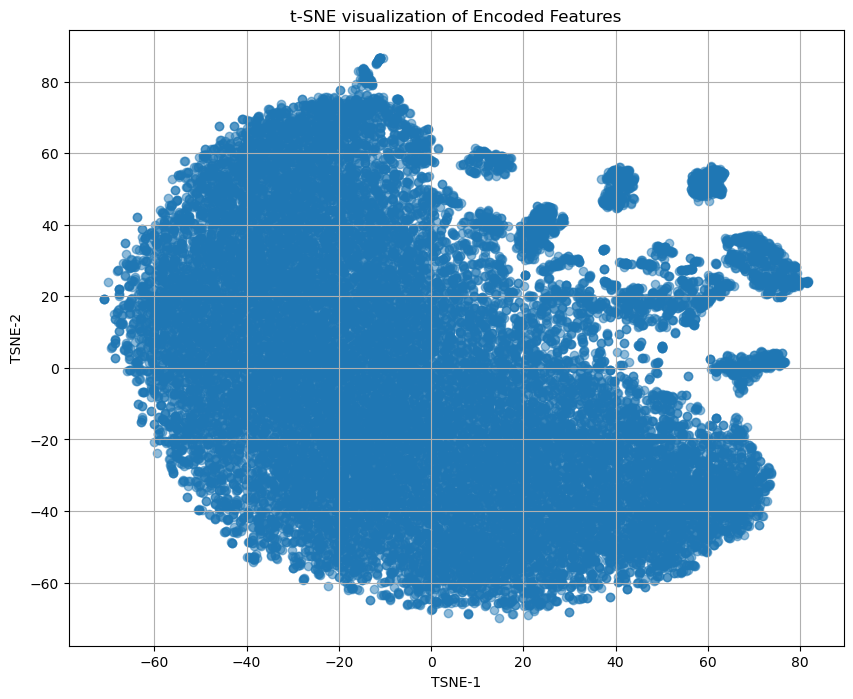

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(cell_encoded_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE visualization of Encoded Features')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.grid(True)
plt.show()

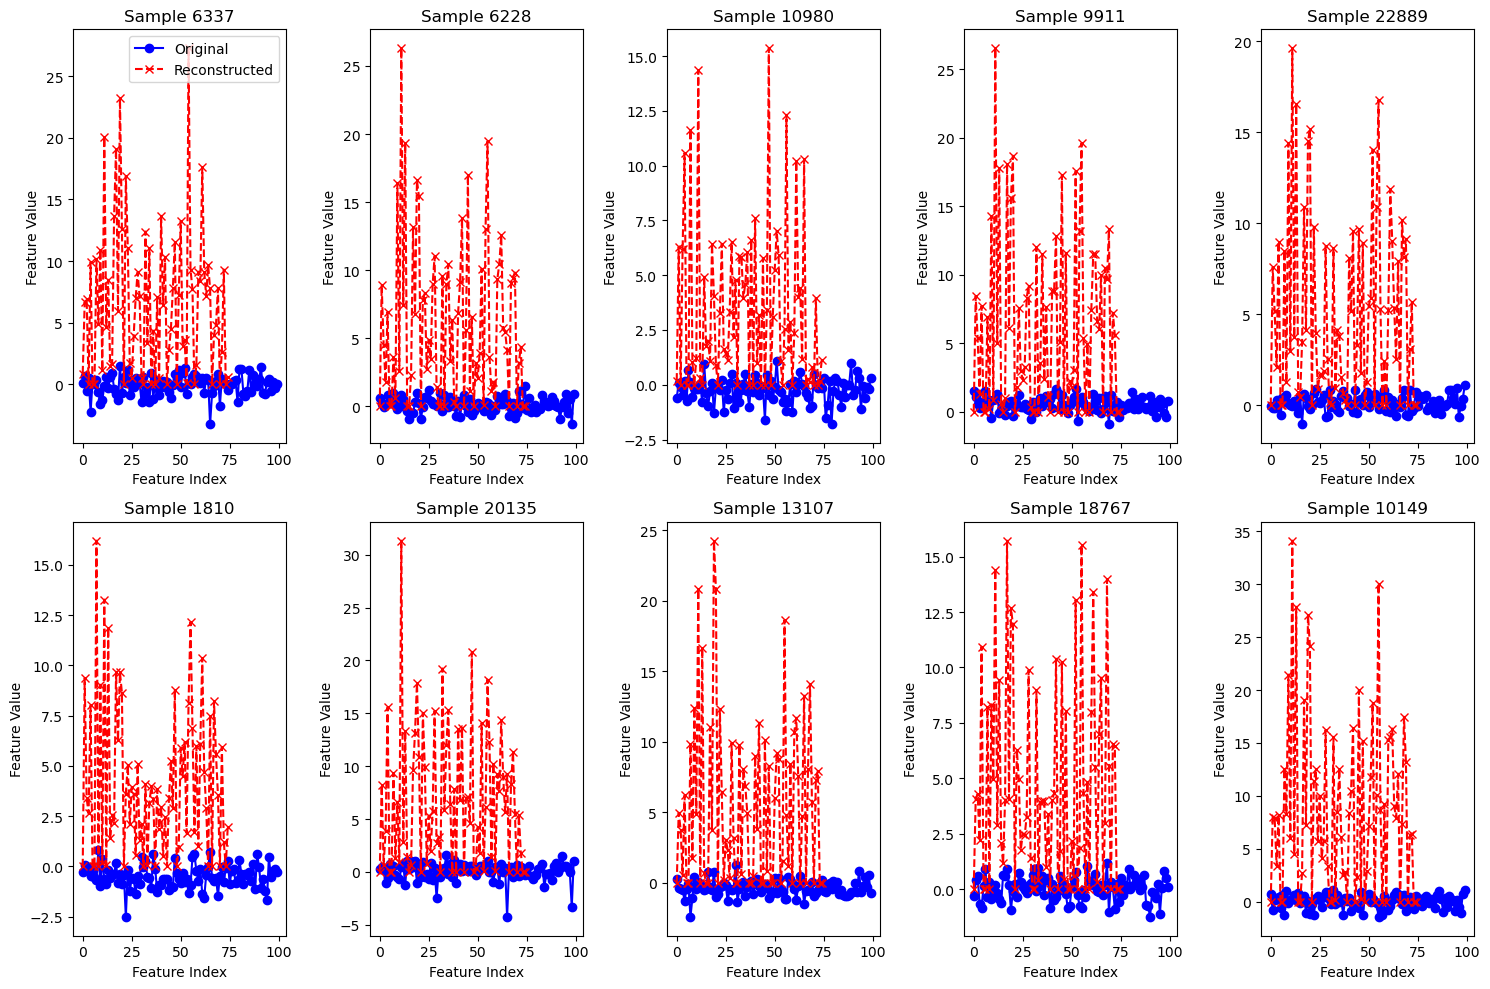

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Choose random indices to plot comparisons
indices = np.random.choice(x[cell_features].shape[0], 10, replace=False)

# Extract original and reconstructed data for these indices
original_features = x[cell_features].iloc[indices].values
reconstructed_features = cell_encoded_features[indices]

# Visualization
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.plot(original_features[i], label='Original', marker='o', linestyle='-', color='blue')
    plt.plot(reconstructed_features[i], label='Reconstructed', marker='x', linestyle='--', color='red')
    plt.title(f'Sample {idx}')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    if i == 0:
        plt.legend()
    plt.tight_layout()
plt.show()

#### Gene Features

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set the random seed for reproducibility
tf.random.set_seed(42)

# Data preparation
x_gene_features = np.array(x[gene_features])  # Ensure x[gene_features] is converted to a numpy array if not already
X_train, X_val = train_test_split(x_gene_features, test_size=0.2, random_state=42)

# Define learning rate schedule and optimizer
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)
optimizer = Adam(learning_rate=lr_schedule)

# Model architecture
inputs = Input(shape=(772,))
encoder_1 = Dense(512, activation='relu')(inputs)
batch_norm = BatchNormalization()(encoder_1)
encoder_2 = Dense(420, activation='relu')(batch_norm)
decoder_1 = Dense(420, activation='relu')(encoder_2)
batch_norm = BatchNormalization()(decoder_1)
decoder_2 = Dense(512, activation='relu')(batch_norm)
batch_norm = BatchNormalization()(decoder_2)
decoder_3 = Dense(772)(decoder_2) 
model = Model(inputs=inputs, outputs=decoder_3)
model.compile(optimizer=optimizer, loss='mse')

# Fit the model
model.fit(
    X_train, 
    X_train, 
    batch_size=512, 
    epochs=200, 
    validation_data=(X_val, X_val)  # Include validation data here
)

# Extract encoded features if needed
gene_encoder_model = Model(inputs=inputs, outputs=encoder_2)
gene_encoded_features = gene_encoder_model.predict(x_gene_features)


2024-05-04 17:58:25.634126: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-04 17:58:25.634160: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-04 17:58:25.634168: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-04 17:58:25.634214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-04 17:58:25.634234: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2024-05-04 17:58:26.696994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-04 17:58:26.759803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


38/38 [==============================] - 4s 56ms/step - loss: 0.9857 - val_loss: 5.6758
Epoch 2/200
38/38 [==============================] - 1s 17ms/step - loss: 0.7105 - val_loss: 1.2255
Epoch 3/200
38/38 [==============================] - 1s 20ms/step - loss: 0.6327 - val_loss: 0.6620
Epoch 4/200
38/38 [==============================] - 1s 17ms/step - loss: 0.5834 - val_loss: 0.6012
Epoch 5/200
38/38 [==============================] - 1s 17ms/step - loss: 0.5446 - val_loss: 0.5538
Epoch 6/200
38/38 [==============================] - 1s 17ms/step - loss: 0.5151 - val_loss: 0.5650
Epoch 7/200
38/38 [==============================] - 1s 17ms/step - loss: 0.5059 - val_loss: 0.5165
Epoch 8/200
38/38 [==============================] - 1s 17ms/step - loss: 0.4743 - val_loss: 0.4883
Epoch 9/200
38/38 [==============================] - 1s 16ms/step - loss: 0.4516 - val_loss: 0.4763
Epoch 10/200
38/38 [==============================] - 1s 17ms/step - loss: 0.4318 - val_loss: 0.4442
Epoch 11/20

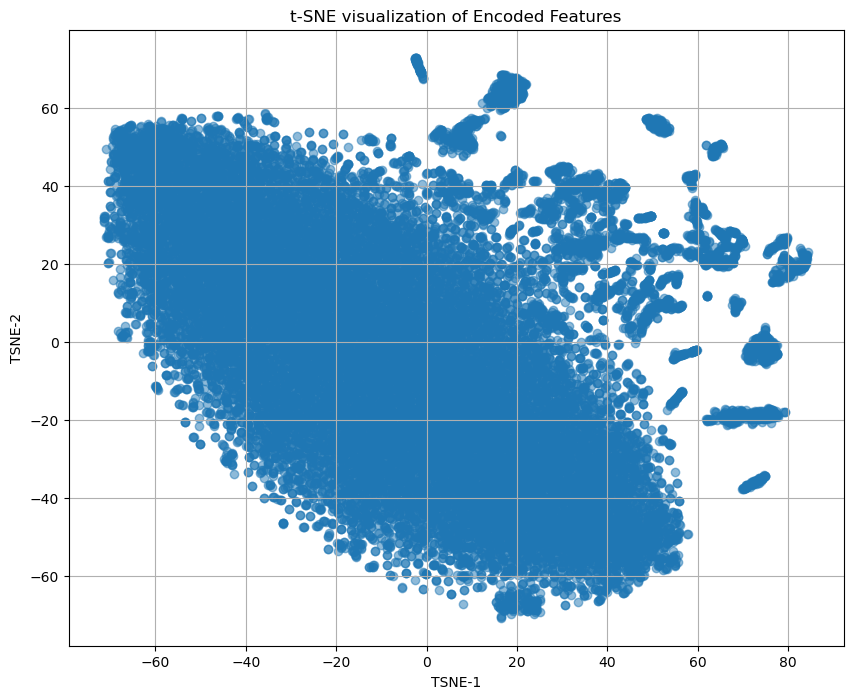

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(gene_encoded_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE visualization of Encoded Features')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.grid(True)
plt.show()

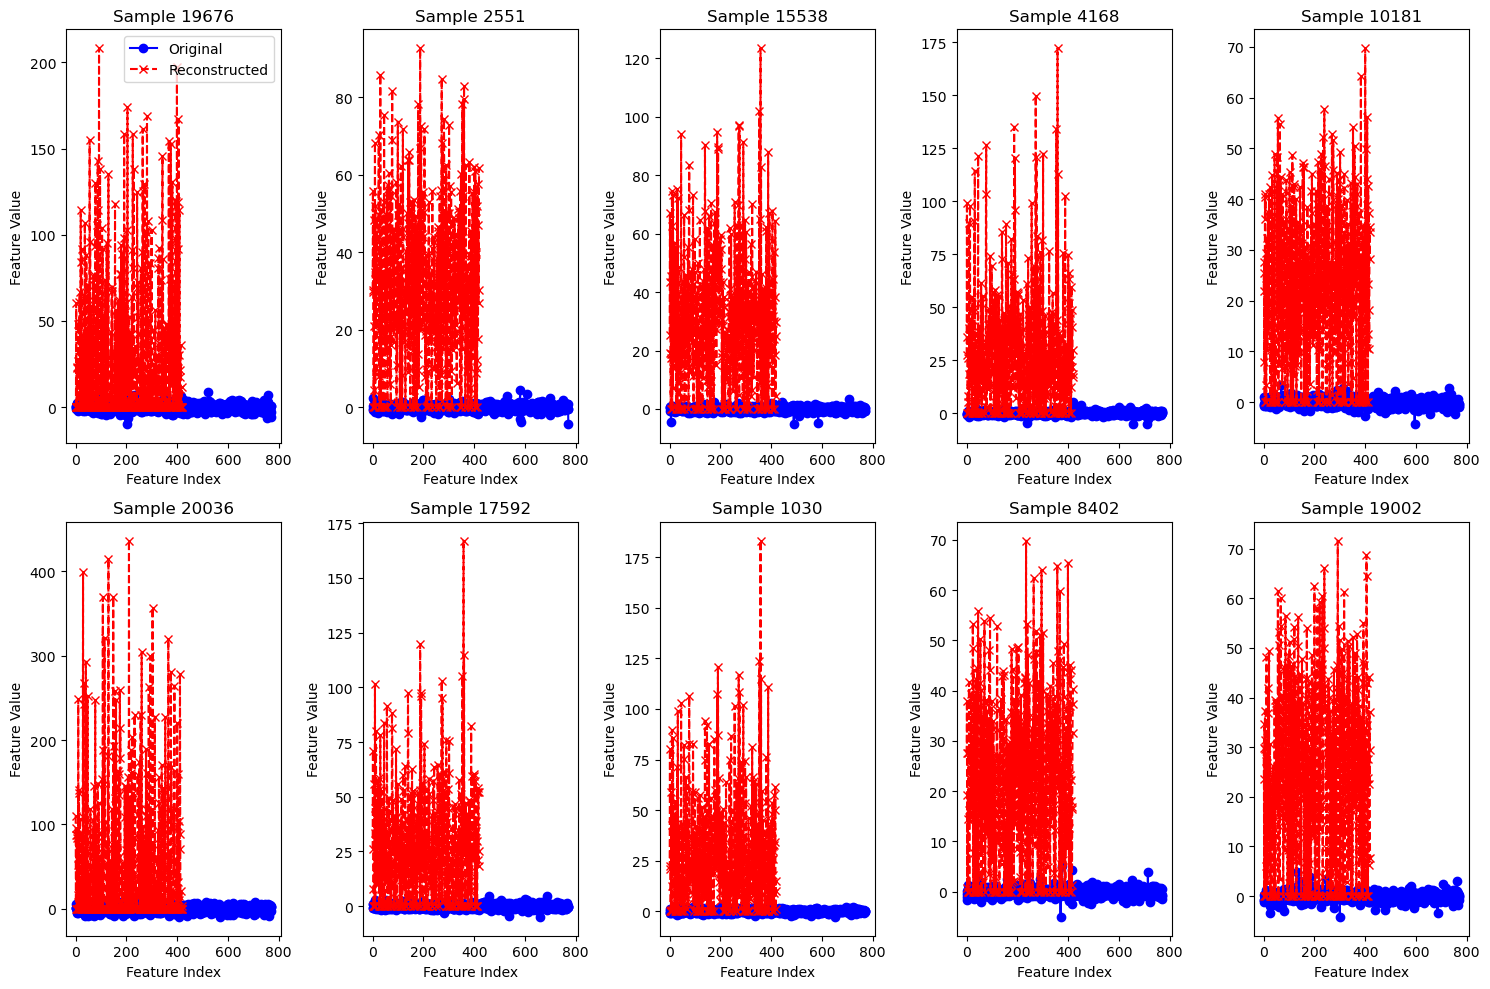

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Choose random indices to plot comparisons
indices = np.random.choice(x[gene_features].shape[0], 10, replace=False)

# Extract original and reconstructed data for these indices
original_features = x[gene_features].iloc[indices].values
reconstructed_features = gene_encoded_features[indices]

# Visualization
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.plot(original_features[i], label='Original', marker='o', linestyle='-', color='blue')
    plt.plot(reconstructed_features[i], label='Reconstructed', marker='x', linestyle='--', color='red')
    plt.title(f'Sample {idx}')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    if i == 0:
        plt.legend()
    plt.tight_layout()
plt.show()